In [3]:
from keras.models import Sequential
from keras.layers import Conv1D,Input,Dense,Flatten
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [4]:
sample_length = 128

In [5]:
aggregate_power = pd.read_csv('../master_data/house_1/channel_1.dat', header = None,
                                names = ["Time","Power"], delim_whitespace = True,
                                index_col = 0)
aggregate_power.index = pd.to_datetime(aggregate_power.index,unit='s')
#mw_activations = pd.read_csv('../master_data/nilm/mw_activations.dat', #header = None,
#                                delim_whitespace = True,
#                                names = ['index', 'start','end','mean_power'],
#                                index_col = 0)
kettle_activations = pd.read_csv('../master_data/nilm/kettle_activations.dat', header = 0,
                                delim_whitespace = True,
                                names = ['index', 'start','end','mean_power'],
                                index_col = 0, parse_dates = ['start','end'],
                                date_parser = pd.core.tools.datetimes.to_datetime)
#dw_activations = pd.read_csv('../master_data/nilm/dw_activations.dat', #header = None,
#                                delim_whitespace = True,
#                                names = ['index', 'start','end','mean_power'],
#                                index_col = 0)
kettle_activations.head()

/home/bjornif/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,start,end,mean_power
index,,,
0,2012-11-10 08:49:42,2012-11-10 08:51:45,2311.157895
1,2012-11-10 17:22:40,2012-11-10 17:24:05,2282.692308
2,2012-11-11 08:28:41,2012-11-11 08:30:47,2261.200000
3,2012-11-11 11:35:09,2012-11-11 11:38:09,2282.896552
4,2012-11-11 11:44:35,2012-11-11 11:46:59,2285.956522


2013-01-05 13:10:13 2013-01-05 13:11:44


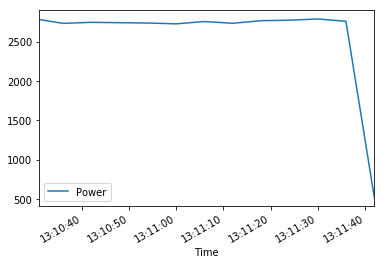

In [61]:
for _ in range(1):
    dice = np.random.randint(0,100)
    start = kettle_activations.iloc[dice]['start']
    end = kettle_activations.iloc[dice]['end']
    print(start,end)
    aggregate_power[start:end].plot()
    plt.show()

In [4]:
(kettle_activations['end'] - kettle_activations['start']).sort_values().tail(40)

index
2888   00:04:38
2320   00:04:38
3195   00:04:38
3085   00:04:39
2913   00:04:40
3277   00:04:41
2542   00:04:43
2939   00:04:46
3060   00:04:46
652    00:04:46
1838   00:04:49
564    00:04:51
3009   00:04:55
2777   00:04:57
3270   00:04:59
3117   00:04:59
1491   00:05:00
3137   00:05:01
2928   00:05:02
53     00:05:11
2114   00:05:14
3103   00:05:18
2988   00:05:23
1712   00:05:24
3036   00:05:32
3019   00:05:33
3140   00:05:33
3077   00:06:19
1250   00:06:19
105    00:06:22
1133   00:06:22
1566   00:06:26
355    00:06:28
1063   00:07:16
1193   00:07:17
2344   00:07:49
1490   00:07:54
1221   00:07:58
1119   00:08:57
3092   00:11:25
dtype: timedelta64[ns]

#### Note:
The minimal run time of the kettle is 30 seconds.

It is not entirely clear to me how the authors of the paper created their training sets (only that they extended them substantially with syntethic data). Below is an attempt to create a training set in the spirit of the paper, by randomly selecting "empty" and "meaningful" intervals with a 50/50 probability.

In [64]:
def clean_power_series(aggregate_power, activations):
    
    temp_ap = aggregate_power.copy()
    
    n = activations.shape[0]

    #pcent = int(n/100)
    ap_sans_activations = pd.DataFrame()
    
    ap_sans_activations.append(temp_ap[:activations['start'][0]])
    
    for i in range(1,n):
        ap_sans_activations = ap_sans_activations.append(temp_ap[activations['end'][i-1]:activations['start'][i]])
    
    ap_sans_activations.append(temp_ap[activations['end'][i]:])
    
    return ap_sans_activations


def create_training_set(aggregate_power, activations, ap_sans_activations = None, sample_length = 128, pad = 1024):
    training_set = pd.DataFrame(columns = np.linspace(0,1,sample_length))
    training_set_response = pd.DataFrame(columns = ['start','end','mean_power'])

    #aggregate power sans the activation intervals
    if ap_sans_activations is None:
        ap_sans_activations = clean_power_series(aggregate_power,activations)

    n = aggregate_power.shape[0]
    j = 0
    for i in range(activations.shape[0]):
        if i % 100 == 0:
            print(i)
        while True:
            dice = np.random.random()
            if dice < 0.5:
                start = activations['start'][i]
                end = activations['end'][i]
                #randomly place the chosen signal in a window.
                #note that the entire signal is always in the window 
                sample_start = start - pd.Timedelta(np.random.randint(0,pad),unit='s')
                sample_end = end + pd.Timedelta(np.random.randint(0,pad),unit='s')
                sample = aggregate_power[sample_start:sample_end]

                while sample.shape[0] > sample_length:
                    if np.random.random() > 0.5 and end < sample.index[-1]:
                        sample = sample.iloc[:-1]
                    elif start > sample.index[0]:
                        sample = sample.iloc[1:]
                    else:
                        sample = sample.iloc[0:1]
                
                if not sample.shape[0] < sample_length:
                    
                    #sample = sample.reindex(columns=training_set.columns, method='nearest')
                    start_fraction = (start - sample.index[0])/(sample.index[-1] - sample.index[0])
                    end_fraction = (end - sample.index[0])/(sample.index[-1] - sample.index[0])
                    training_set.loc[j] = sample.T.values[0]
                    training_set_response.loc[j] = [start_fraction,end_fraction,activations['mean_power'][i]]
                    j+=1
                
                break
                
                
            ri = np.random.randint(0,ap_sans_activations.shape[0]-sample_length)
            sample = ap_sans_activations.iloc[ri: ri+sample_length]
            training_set.loc[j] = sample.T.values[0]
            training_set_response.loc[j] = [0,0,0]
            j+=1
            
    return training_set, training_set_response



#### Note: 
drop() takes forever, avoid it.<br>


In [65]:
clean_ap = clean_power_series(aggregate_power,kettle_activations)

In [66]:
training_set_kettle, response_kettle = create_training_set(aggregate_power, kettle_activations,
                                                           ap_sans_activations = clean_ap,
                                                          sample_length = sample_length)
training_set_kettle.head()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200


,0.0,0.00787401574803,0.0157480314961,0.0236220472441,0.0314960629921,0.0393700787402,0.0472440944882,0.0551181102362,0.0629921259843,0.0708661417323,...,0.929133858268,0.937007874016,0.944881889764,0.952755905512,0.96062992126,0.968503937008,0.976377952756,0.984251968504,0.992125984252,1.0
0,1912,2293,1897,2275,1942,1983,2262,1884,2298,1877,...,217,426,886,211,907,211,908,940,211,897
1,193,191,195,193,191,191,190,193,191,192,...,342,333,342,351,332,348,269,286,289,299
2,231,252,234,250,227,222,250,232,236,252,...,320,339,334,305,371,343,332,346,351,337
3,172,172,172,172,174,173,172,172,172,174,...,167,169,168,169,167,171,169,168,170,168
4,333,313,327,275,275,267,268,274,267,270,...,270,295,297,282,285,283,284,286,290,281


### Normalization:

As per the paper, done by subtracting sample mean and dividing by a <i>random</i> sample standard deviation.<br>
The normalization parameters are saved so they may be used when testing the model.

start         0.842839
end            1.00507
mean_power     2296.25
Name: 89, dtype: object


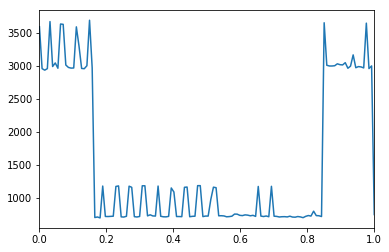

In [108]:
for _ in range(1):
    dice = np.random.randint(0,100)
    training_set_kettle.iloc[dice].plot()
    print(response_kettle.iloc[dice])
    plt.show()

In [131]:
syntethic_data = pd.read_csv('../master_data/nilm/syntethic_data.dat',
                                delim_whitespace = True,
                                index_col = 0)

syntethic_response = pd.read_csv('../master_data/nilm/syntethic_response.dat', header = 0,
                                names = ["Time","start","end","mean_power"], delim_whitespace = True,
                                index_col = 0)

#syntethic_training_set.columns = pd.to_numeric(syntethic_data.columns)
syntethic_response.head()

,start,end,mean_power
Time,,,
0,0.000000,0.000000,0.000000
1,0.755155,0.905928,2240.421053
2,0.640927,0.750322,2789.071429
3,0.000000,0.000000,0.000000
4,0.152605,0.339950,2587.000000


In [280]:
#real_data = pd.concat([training_set_kettle,response_kettle],axis=1)

col_dict = dict(zip(syntethic_data.columns.values,training_set_kettle.columns.values))
X = training_set_kettle.append(syntethic_data.rename(columns=col_dict))

y = response_kettle.append(syntethic_response)

print(X.shape)
print(y.shape)

X_np = np.array(X,dtype=np.float64).reshape((X.shape[0],X.shape[1],1))
y_np = np.array(y,dtype=np.float64).reshape((y.shape[0],y.shape[1]))

#some cleaning (some of the syntethic data contained 0-length signals?)
dirty = []
for i in range(y_np.shape[0]):
    if np.isnan(y_np[i]).any():
        dirty.append(i)
y_np = np.delete(y_np, dirty,axis=0)
X_np = np.delete(X_np, dirty,axis=0)

print("Removed " + str(len(dirty)) + " instances.")
#row_mean = syntethic_data.mean(axis=1)
#syntethic_data_n = syntethic_data.sub(row_mean.T,axis=0)
#rand_sd = syntethic_data.std(axis=1)
#rand_sd = rand_sd.sample(frac=1).reset_index(drop=True)
#syntethic_data_n = syntethic_data_n.div(rand_sd,axis=0)
#syntethic_data_n.head()



(15627, 128)
(15627, 3)
Removed 44 instances.


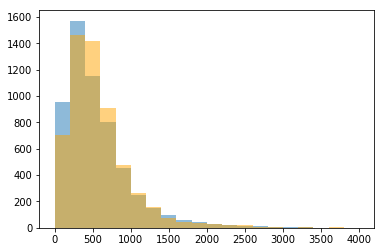

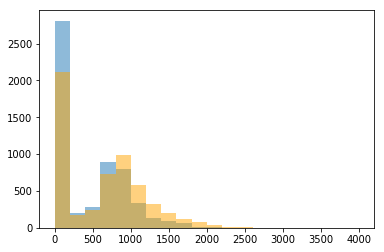

In [281]:
#Tangent: The syntethic data looks a lot like the real data
means_real = training_set_kettle.mean(axis=1).sort_values().reset_index(drop=True)
means_synth = syntethic_data[:means_real.size].mean(axis=1).sort_values().reset_index(drop=True)
plt.hist(means_real,alpha=0.5, bins=20, range=(0,4000))
plt.hist(means_synth,alpha=0.5,color='orange', bins=20, range=(0,4000))
plt.show()

stds_real = training_set_kettle.std(axis=1).sort_values().reset_index(drop=True)
stds_synth = syntethic_data[:stds_real.size].std(axis=1).sort_values().reset_index(drop=True)
plt.hist(stds_real,alpha=0.5,bins=20, range=(0,4000))
plt.hist(stds_synth,alpha=0.5,color='orange',bins=20, range=(0,4000))
plt.show()

In [282]:
mean = X_np.mean()
X_np = X_np - mean
sd = X_np.std(axis=1).mean()
#rand_sd = rand_sd.sample(frac=1).reset_index(drop=True)
X_np /= sd
print("Mean: ", X_np.mean())
print("Std: ", X_np.std())

normalization_params = pd.DataFrame([[mean,sd]],columns=['mean','sd'])
normalization_params.to_csv('../master_data/nilm/normalization_params.csv',sep=' ')

Mean:  1.054152594e-16
Std:  1.5771109766


In [105]:
#data = pd.concat([training_set_kettle,response_kettle],axis=1)
#data = data.sample(frac=1).reset_index(drop=True)

#split = int(data.shape[0]*0.5)
#training_set = data[:split]
#test_set = data[split:]

#syntethic_training_set = pd.concat([syntethic_data,syntethic_response],axis=1)
#col_dict = dict(zip(syntethic_training_set.columns.values,training_set.columns.values))
#training_set = training_set.append(syntethic_training_set.rename(columns=col_dict))
#print(training_set.shape)
#X_train = training_set.iloc[:,:-3]
#y_train = training_set.iloc[:,-3:]

#X_test = test_set.iloc[:,:-3]
#y_test = test_set.iloc[:,-3:]

#X_train_np = np.array(X_train,dtype=np.float64).reshape((X_train.shape[0],X_train.shape[1],1))
#y_train_np = np.array(y_train,dtype=np.float64).reshape((y_train.shape[0],y_train.shape[1]))

#X_test_np = np.array(X_test,dtype=np.float64).reshape((X_test.shape[0],X_test.shape[1],1))
#y_test_np = np.array(y_test,dtype=np.float64).reshape((y_test.shape[0],y_test.shape[1]))

#some cleaning (some of the syntethic data contained 0-length signals?)
#dirty_train = []
#for i in range(y_train_np.shape[0]):
#    if np.isnan(y_train_np[i]).any():
#        dirty_train.append(i)
#y_train_np = np.delete(y_train_np, dirty_train,axis=0)
#X_train_np = np.delete(X_train_np, dirty_train,axis=0)

#dirty_test = []
#for i in range(y_test_np.shape[0]):
#    if np.isnan(y_test_np[i]).any():
#        dirty_test.append(i)
#y_test_np = np.delete(y_test_np, dirty_test,axis=0)
#X_test_np = np.delete(X_test_np, dirty_test,axis=0)



(12813, 131)


In [283]:
#Tensorflow uses shape [samples][height][width][channels] 

layer1 = Conv1D(filters=16, input_shape = (sample_length,1,),kernel_size=4,
                activation='linear',padding='valid', strides=1)
layer2 = Conv1D(filters=16, kernel_size=4,activation='linear',padding='valid', strides=1)
layer2_b = Flatten()
layer3 = Dense(units=4096,activation='relu')
layer4 = Dense(units=3072,activation='relu')
layer5 = Dense(units=2048,activation='relu')
layer6 = Dense(units=512,activation='relu')
outputs = Dense(units=3,activation='linear')

model = Sequential()

model.add(layer1)
model.add(layer2)
model.add(layer2_b)
model.add(layer3)
model.add(layer4)
model.add(layer5)
model.add(layer6)
model.add(outputs)

In [284]:

print(X_np.shape, y_np.shape)
model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['mae'])

model.fit(X_np, y_np, batch_size=64,verbose=1,epochs=10)

(15583, 128, 1) (15583, 3)
Epoch 1/10
15583/15583 [==============================] - 181s 12ms/step - loss: 376888.7166 - mean_absolute_error: 220.2934
Epoch 2/10
15583/15583 [==============================] - 183s 12ms/step - loss: 214145.7250 - mean_absolute_error: 165.8566
Epoch 3/10
15583/15583 [==============================] - 165s 11ms/step - loss: 191569.7826 - mean_absolute_error: 154.7374
Epoch 4/10
15583/15583 [==============================] - 187s 12ms/step - loss: 180063.4963 - mean_absolute_error: 147.4242
Epoch 5/10
15583/15583 [==============================] - 206s 13ms/step - loss: 172279.3421 - mean_absolute_error: 143.3909
Epoch 6/10
15583/15583 [==============================] - 164s 11ms/step - loss: 167002.1644 - mean_absolute_error: 139.9268
Epoch 7/10
15583/15583 [==============================] - 168s 11ms/step - loss: 161981.9889 - mean_absolute_error: 137.2595
Epoch 8/10
15583/15583 [==============================] - 161s 10ms/step - loss: 154992.7546 - mea

In [286]:
model.save('../master_data/nilm/models/model0118.h5')